# AI Applications

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

The aim of this project is to use a pre-trained network(MobileNet), and adjust it to accurately classify different species of flowers commonly occuring in the United Kingdom. The [dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) used to train the model is of 102 flow categories. An example of the dataset can be seen below.

<img src='https://github.com/adhamalhossary/image_classifier/blob/master/assets/Flowers.png?raw=1' width=500px>

This project is broken down into multiple steps:

* Loading of the image dataset and creating a pipeline.
* Building and training an image classifier on this dataset.
* Using the trained model to perform inference on flower images.

## Import Resources

In [1]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

     |████████████████████████████████| 3.5MB 6.1MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Used to hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Importing of necessary packages

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import json

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.3.0
	• tf.keras version: 2.4.0
	• Running on GPU


## Load the Dataset

`tensorflow_datasets` is used to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.

In [5]:
# Datasets are loaded using tfds.load
(training_set,validation_set, testing_set), dataset_info = tfds.load("oxford_flowers102", 
                                                                     split=["train","validation", "test"],
                                                                     as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteG1HOCF/oxford_flowers102-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteG1HOCF/oxford_flowers102-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteG1HOCF/oxford_flowers102-validation.tfrecord
Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [6]:
# Used to print all information about the dataset
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

All sets have been successfully loaded and `dataset_info` has been used to display important information about the dataset. However, there is alot of information and it would be useful if we can only print key information such as the number of classes and images in each set.



In [7]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = dataset_info.splits['train'].num_examples
num_testing_examples = dataset_info.splits['test'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples

print('The Dataset has:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images in the training set'.format(num_training_examples))
print('\u2022 {:,} images in the validation set'.format(num_validation_examples))
print('\u2022 {:,} images in the testing set'.format(num_testing_examples))

The Dataset has:
• 102 classes
• 1,020 images in the training set
• 1,020 images in the validation set
• 6,149 images in the testing set


Knowing the shape of the images is key in training the model. It is also important to see if the images have the same shape or if they differ from each other.

In [8]:
# Prints the shape, type and corresponding label of 3 images in the training_set.

x=1
for image, label in training_set.take(3):
    print('Image {:,} has:'.format(x))
    print('\u2022 shape of image:', image.shape, '\n\u2022 dtype of image:', image.dtype,
          '\n\u2022 label:', label.numpy(), '\n\u2022 dtype of label:', label.dtype)
    x+=1

Image 1 has:
• shape of image: (500, 667, 3) 
• dtype of image: <dtype: 'uint8'> 
• label: 72 
• dtype of label: <dtype: 'int64'>
Image 2 has:
• shape of image: (500, 666, 3) 
• dtype of image: <dtype: 'uint8'> 
• label: 84 
• dtype of label: <dtype: 'int64'>
Image 3 has:
• shape of image: (670, 500, 3) 
• dtype of image: <dtype: 'uint8'> 
• label: 70 
• dtype of label: <dtype: 'int64'>


It can be seen that the shape of all three images are different from each other. The images will have to be normalized and resized to 224x224 pixels, as the shape of our input tensor must match the size of the images MobileNet was trained on, namely `(224,224,3)`. This step is covered below in the __Create Pipeline__ Section.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but they will also need to be normalized and resized to the appropriate size for usage by the model.

Key information about the dataset is now known, but we still haven't seen how an image in our dataset looks like and how labels are represented.

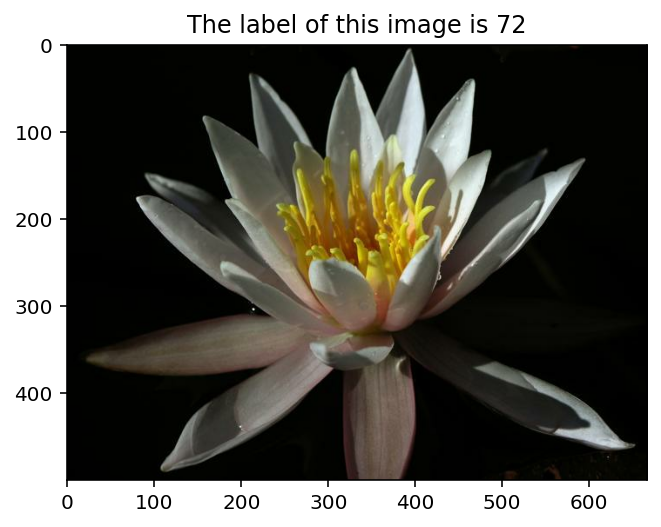

In [9]:
# Plots 1 image from the training set and sets the corresponding image label as the title.

for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title('The label of this image is {:,}'.format(label))
plt.show()

The image does indeed look clearly like a flower, and the labels are represented as numerical values where each value represents a unqiue flower class.

### Label Mapping

It would clearer if the names of the flowers could be used instead of numerical labels. The `label_map.json` maps the numerical labels as seen in the title of the image above to the names of the flowers. It is a json object which is read using the [`json` module](https://docs.python.org/3.7/library/json.html).

In [10]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [11]:
print(class_names)
print(len(class_names))

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

The dictionary contains 102 labels which is the same as the number of classes in all sets. However, the labels are represented as strings and need to be changed to integers for successful mapping ,as the labels in the dataset are represented as integers.

In [12]:
# changes all dictionary keys from strings to integers

class_names = {int(key): class_names[key] for key in class_names}

print(class_names)

{21: 'fire lily', 3: 'canterbury bells', 45: 'bolero deep blue', 1: 'pink primrose', 34: 'mexican aster', 27: 'prince of wales feathers', 7: 'moon orchid', 16: 'globe-flower', 25: 'grape hyacinth', 26: 'corn poppy', 79: 'toad lily', 39: 'siam tulip', 24: 'red ginger', 67: 'spring crocus', 35: 'alpine sea holly', 32: 'garden phlox', 10: 'globe thistle', 6: 'tiger lily', 93: 'ball moss', 33: 'love in the mist', 9: 'monkshood', 102: 'blackberry lily', 14: 'spear thistle', 19: 'balloon flower', 100: 'blanket flower', 13: 'king protea', 49: 'oxeye daisy', 15: 'yellow iris', 61: 'cautleya spicata', 31: 'carnation', 64: 'silverbush', 68: 'bearded iris', 63: 'black-eyed susan', 69: 'windflower', 62: 'japanese anemone', 20: 'giant white arum lily', 38: 'great masterwort', 4: 'sweet pea', 86: 'tree mallow', 101: 'trumpet creeper', 42: 'daffodil', 22: 'pincushion flower', 2: 'hard-leaved pocket orchid', 54: 'sunflower', 66: 'osteospermum', 70: 'tree poppy', 85: 'desert-rose', 99: 'bromelia', 87: 

Now that we have the name of the flowers, let's print the same image above but with the flower name.

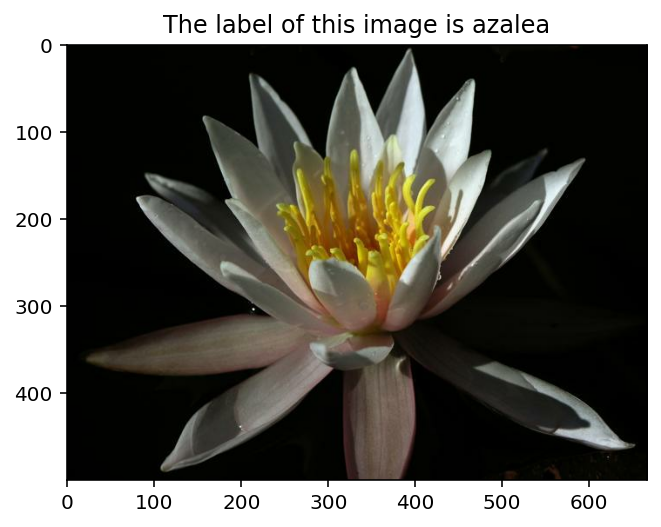

In [13]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    name = class_names[label]

plt.imshow(image)
plt.title('The label of this image is {:}'.format(name))
plt.show()

## Create Pipeline

As mentioned before, the sizes of the images in the sets vary. A pipeline will be created to resize and normalize the images so that it can be fed into the neural network.

All images will be resized to `(224,224,3)`, and they will be normalized by dividing all pixel values by 255. To achieve this the `dtype` of the images need to be changed from `uint8` to `float32`  (32-bit single-precision floating-point numbers) using the `tf.cast` function.

In [14]:
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = testing_set.map(format_image).batch(batch_size).prefetch(1)

# Building and Training the Classifier

As mentioned earlier, we will use a pre-trained network called MobileNet. MobileNet is a state-of-the-art convolutional neural network that is widely used for classification, object detection and semantic segmentation in mobile vision applications.

The MobileNet model will be used as the first layer of the Sequential model. It will be responsible for extracting the features of our images.


In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

The weights and biases need to be freezed to avoid modifying them in training as this will negatively affect the performance of the model. This will be done by setting the parameters of our model to non_trainable.

In [16]:
feature_extractor.trainable = False

The model will now be created by using the `feature_extractor` as the first layer of the Sequential model and adding a classification layer to it. Since the dataset has 102 classes, an output layer with 102 units is to be created.



In [17]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


As seen above, a GPU is used accelerate the time taken to train the model.

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 10

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
32/32 [==============================] - 9s 281ms/step - loss: 4.2225 - accuracy: 0.1167 - val_loss: 3.1095 - val_accuracy: 0.3686
Epoch 2/10
32/32 [==============================] - 8s 259ms/step - loss: 2.0404 - accuracy: 0.6971 - val_loss: 2.0087 - val_accuracy: 0.6549
Epoch 3/10
32/32 [==============================] - 8s 259ms/step - loss: 1.0756 - accuracy: 0.9118 - val_loss: 1.5406 - val_accuracy: 0.7265
Epoch 4/10
32/32 [==============================] - 8s 260ms/step - loss: 0.6502 - accuracy: 0.9627 - val_loss: 1.3048 - val_accuracy: 0.7431
Epoch 5/10
32/32 [==============================] - 8s 261ms/step - loss: 0.4345 - accuracy: 0.9853 - val_loss: 1.1743 - val_accuracy: 0.7725
Epoch 6/10
32/32 [==============================] - 8s 260ms/step - loss: 0.3116 - accuracy: 0.9922 - val_loss: 1.0840 - val_accuracy: 0.7961
Epoch 7/10
32/32 [==============================] - 8s 262ms/step - loss: 0.2345 - accuracy: 0.9951 - val_loss: 1.0189 - val_accuracy: 0.8010
Epoch 

It can be seen that at the last Epoch the model achieves a perfect accuracy of 100% on the training set and 81% of the validation set. However, it will be more insightful to see the performance of the model on both sets as the number of Epochs increase.

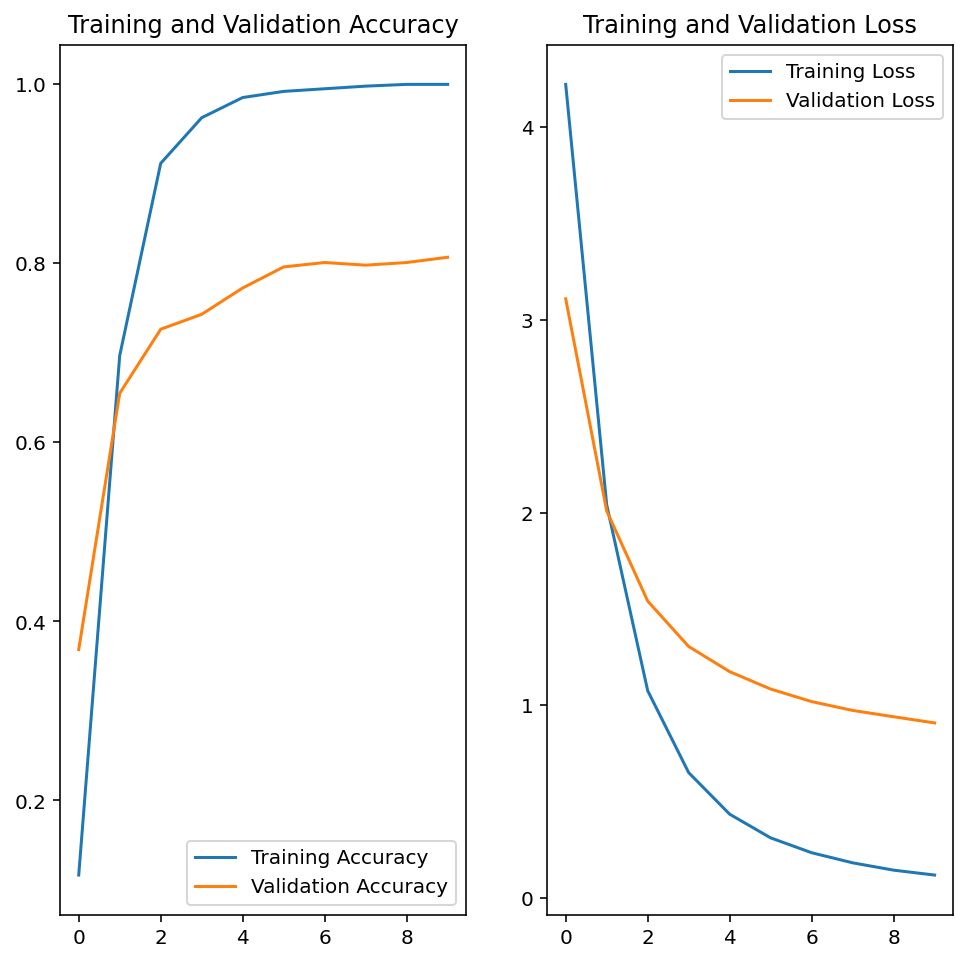

In [20]:
# Plots the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The graphs show that the performance of the model on the training and validation set increases significantly from the first Epoch to the fifth Epoch and starts to stabilize after. Next, the model's performance on the test set will be evaluated.

## Testing the Network

In [21]:
loss, accuracy = model.evaluate(testing_batches)

193/193 [==============================] - 26s 137ms/step - loss: 1.0297 - accuracy: 0.7670


The model achieves an accuracy of 77%, which shows that it has been trained well and can make accurate predictions on new images.

## Saving the Model

Now that the network has been trained, it needs to be saved to be used later in the command line application.

In [22]:
saved_keras_model_filepath = 'flower_image_classifier.h5'

model.save(saved_keras_model_filepath)

## Loading of the Keras Model

The model saved above will be loaded to make sure it works properly. This is to avoid facing any unexpected behaviour in the command line application.

In [23]:
reloaded_keras_model = tf.keras.models.load_model((saved_keras_model_filepath),
                                                  custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

The model is now trained and can make accurate predictions on new images. However, the test set was resized and normalized to be fed into the network. If new images are to be introduced to the model for predictions, they will have to be resized and normalized as well. 

A set of functions will be created to prepare the images and make quick predictions. The `process_image` function created below will be used to normalize and resize the images, and the `predict` function will be used to return the **top K labels** along with the probabilities. These functions will also be used in the command line application.

### Image Pre-processing

In [24]:
# process_image resizes and normalizes the data, and returns the image as a numpy array

def process_image(image):

  tensor_image = tf.image.resize(image,(224,224))
  tensor_image /= 255
  numpy_image = tensor_image.numpy()

  return numpy_image

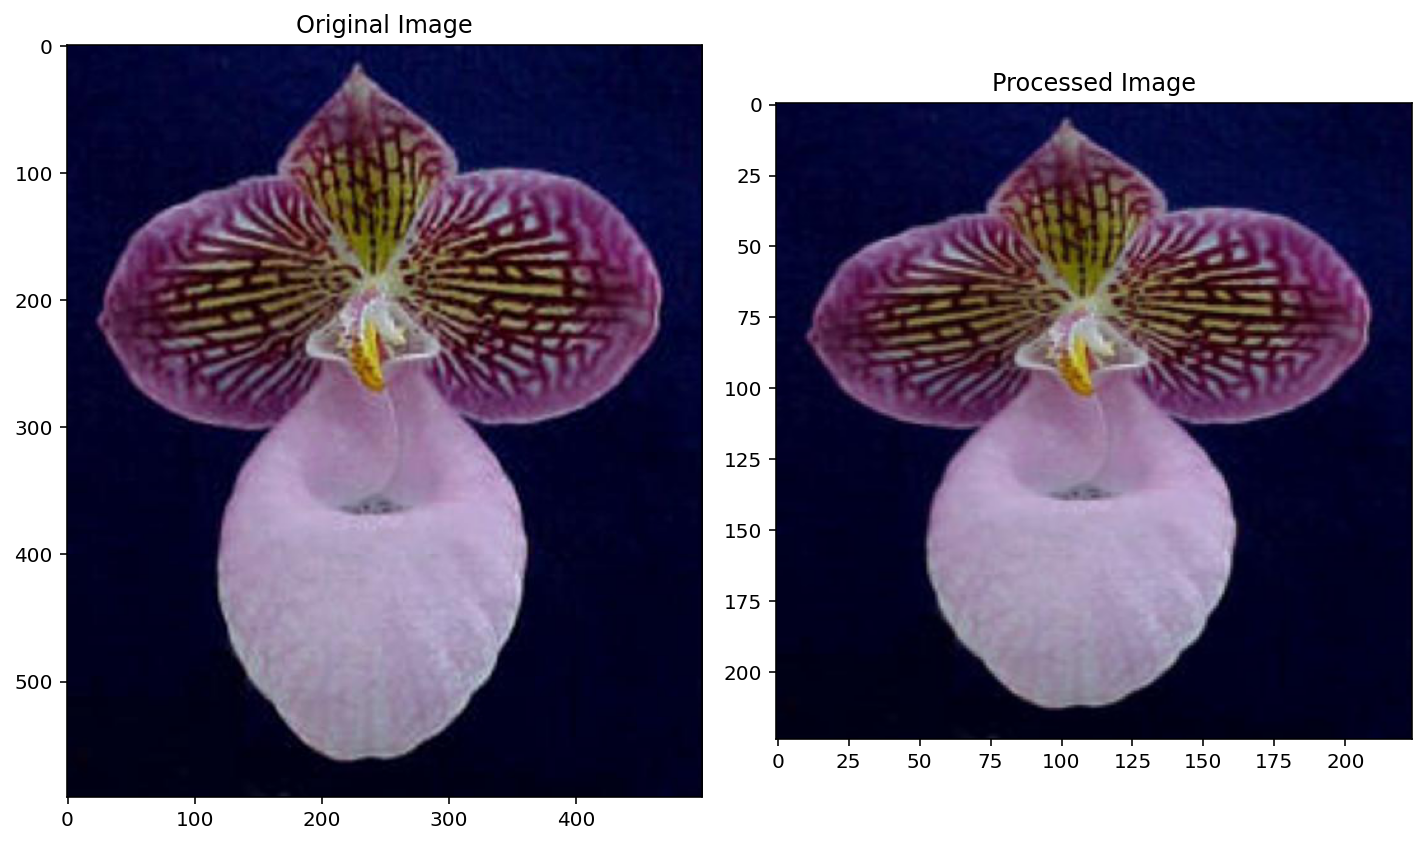

In [25]:
# Tests if the process_image function is working properly

from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Now that the `process_image` function is working properly, it is time to create the predict function.



### Inference

In [26]:
# predict function takes in the image_path, model and number representing the top K most likely class labels.
# It then returns two numpy arrays containing the top K labels and probabilities, and also returns the processed test image

def predict(image_path, model, top_k):

  im = Image.open(image_path)
  test_image = np.asarray(im)
  processed_test_image = process_image(test_image)
  expanded_test_image = np.expand_dims(processed_test_image, axis=0)
    
  predictions = model.predict(expanded_test_image)

  top_k_values, top_k_indices = tf.nn.top_k(predictions, k=top_k)

  top_k_values = top_k_values.numpy()
  top_k_labels = (top_k_indices+1).numpy()

  return top_k_values, top_k_labels, processed_test_image

# Sanity Check

To check that the `predict` function is working properly, it will be tested on all images in the test_images folder. The processed images will be printed alongside a bar chart representing the top K labels with thier probabilities.

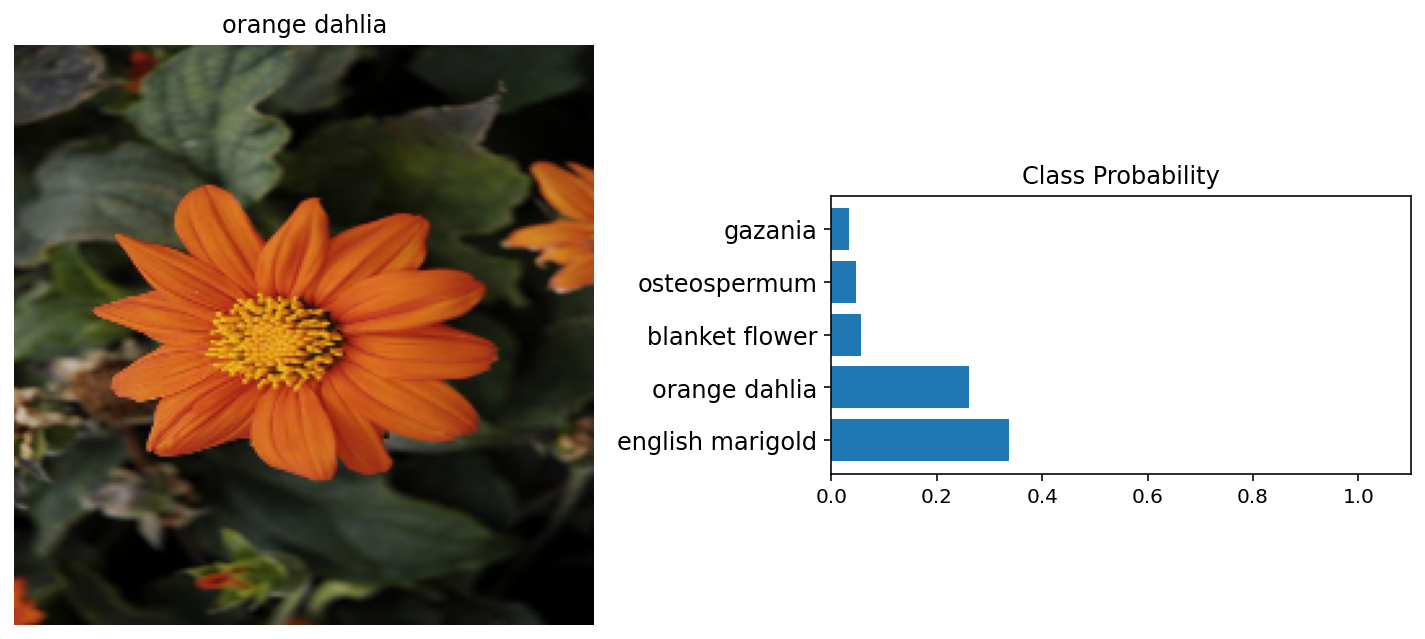

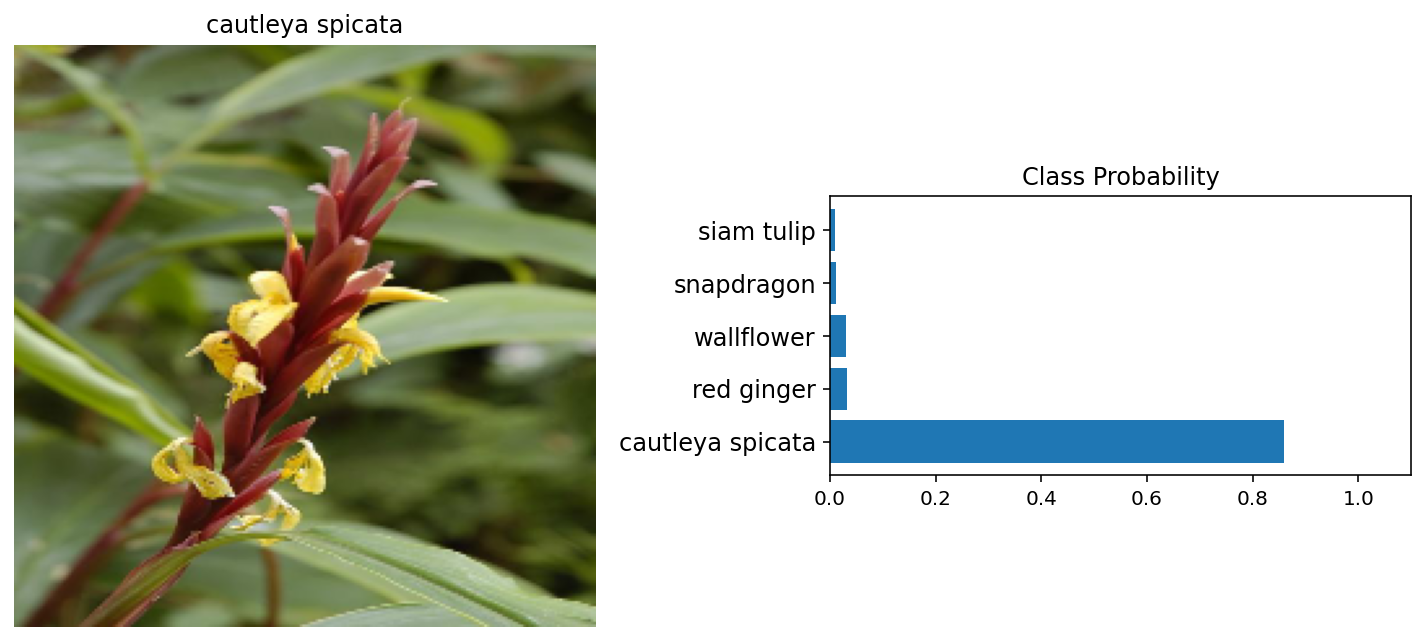

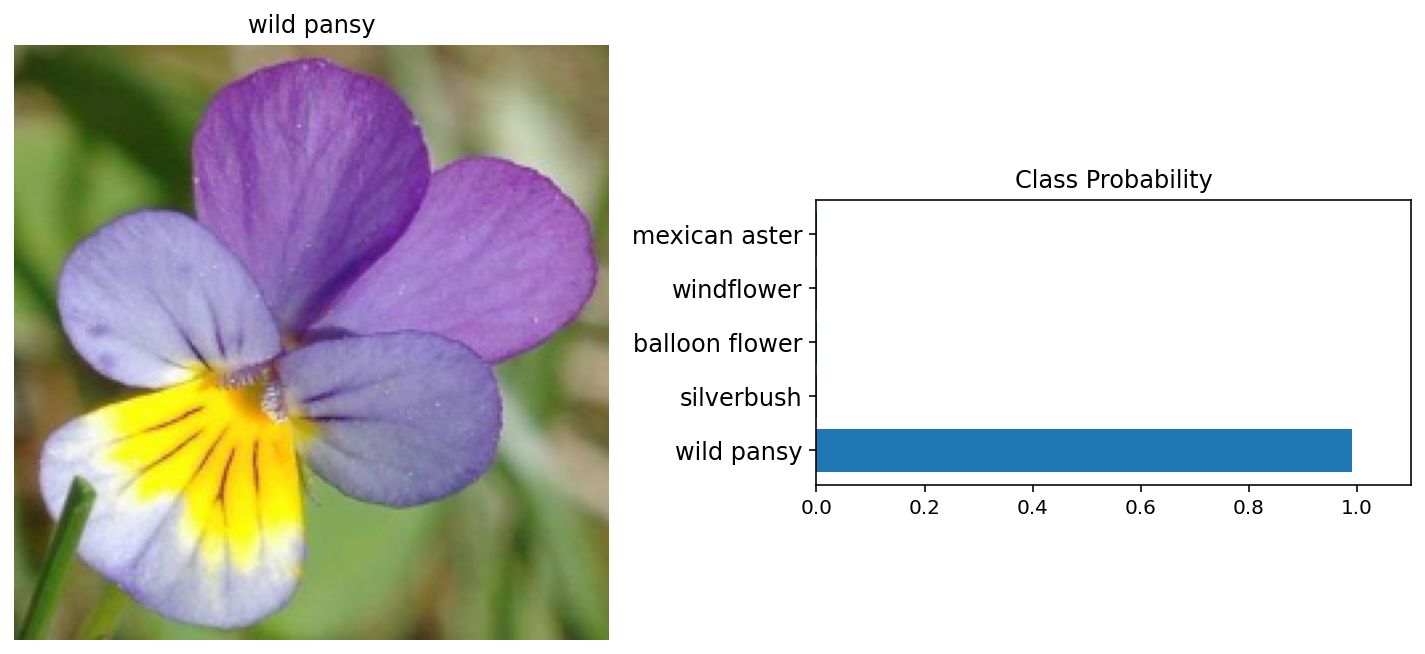

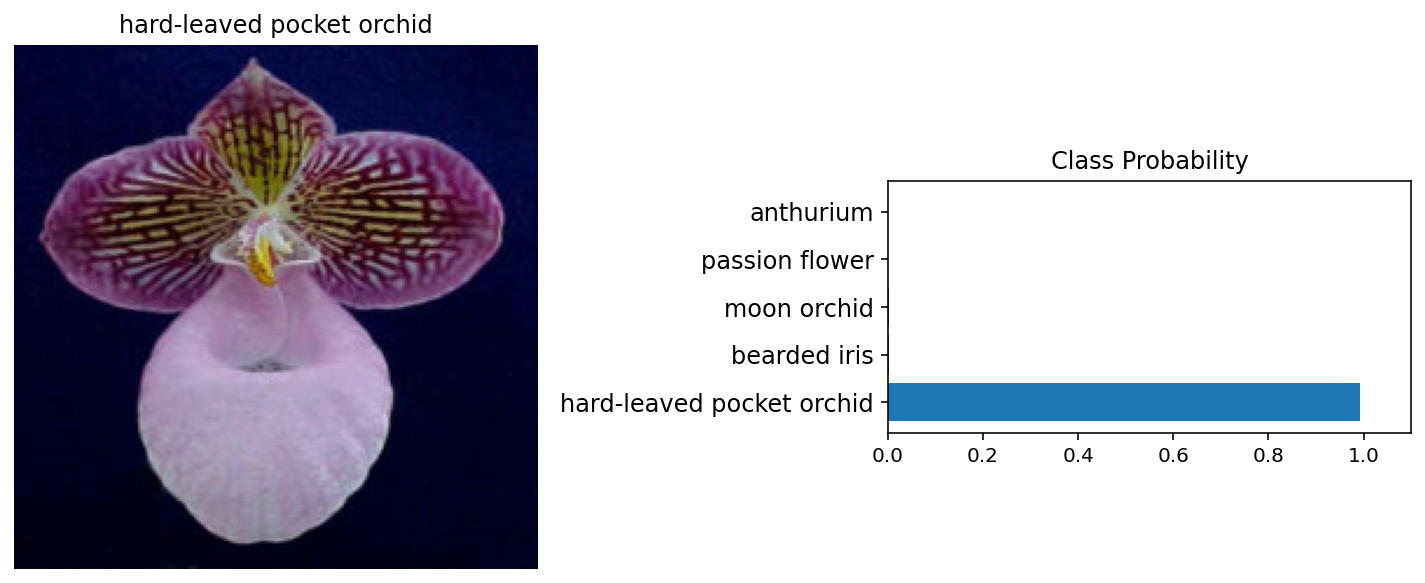

In [27]:
import os

directory = './test_images'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
      image_path = os.path.join(directory, filename)

      probs, labels, image = predict(image_path, reloaded_keras_model, 5)

      class_labels = [class_names.get(label) for label in labels[0]]

      fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
      ax1.imshow(image)
      ax1.axis('off')
      ax1.set_title(filename.strip('.jpg').replace('_'," "))

      ax2.barh(np.arange(5), probs[0])
      ax2.set_aspect(0.1)
      ax2.set_yticks(np.arange(5))
      ax2.set_yticklabels(class_labels, size='large');
      ax2.set_title('Class Probability')
      ax2.set_xlim(0, 1.1)
      plt.tight_layout()

The graphs above show that the functions are working as expected, and that the model can accurately predict the correct class of the flower images.